In [ ]:
!nvidia-smi

Tue Feb  3 06:04:48 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 下载GitHub上的zip文件，-O 参数指定保存到Colab的文件名（保持原名，方便识别）
!mv /content/stage1_train.zip /content/drive/MyDrive/Kaggle_Datasets/stage1_train.zip

In [ ]:
!unzip /content/drive/MyDrive/Kaggle_Datasets/stage1_train.zip -d /content/data

Archive:  /content/drive/MyDrive/Kaggle_Datasets/stage1_train.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/drive/MyDrive/Kaggle_Datasets/stage1_train.zip or
        /content/drive/MyDrive/Kaggle_Datasets/stage1_train.zip.zip, and cannot find /content/drive/MyDrive/Kaggle_Datasets/stage1_train.zip.ZIP, period.


In [5]:
!unzip /content/drive/MyDrive/stage1_train.zip -d /content/Kaggle_Datasets/

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/Kaggle_Datasets/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/160cf18b03df69978e2ed33335afcd781ebebf4ee42df566aaa6fd0aee66ac93.png  
  inflating: /content/Kaggle_Datasets/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/16d3bf2426e9cda0e4f435de3a0c260d17be460f1c834c1282dfd68f9fcf7509.png  
  inflating: /content/Kaggle_Datasets/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1cfe69ef1dec8963e05ba8386a956af0073ba0bec2cc8ba534df81ef6dee905a.png  
  inflating: /content/Kaggle_Datasets/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1d2543cd2a8134ac2ca091a230bd15270826f8dd83c6594550b7f0fc85a15f8e.png  
  inflating: /content/Kaggle_Datasets/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/24b50e6e3406e513d47ddfa9bd85505a95a266858cffc730a9ad7bc99936b800.png  
  inflating: /content/Kaggle_Datasets/d35f25c8e3f7fca5232fc4d5e3faf14b025

In [6]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# 检查 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
!nvidia-smi

Using device: cuda
Thu Feb  5 02:14:27 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------

In [7]:
def bio_preprocess(img):  # 输入是 numpy array (灰度图)
    blurred = cv2.medianBlur(img, 5)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(blurred)
    return enhanced

class NucleiDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.sample_ids = [f for f in os.listdir(root_dir) if not f.startswith('.')]  # 过滤隐藏文件

    def __len__(self):
        return len(self.sample_ids)

    def __getitem__(self, idx):
        sample_id = self.sample_ids[idx]
        sample_path = os.path.join(self.root_dir, sample_id)

        # 读取原图（灰度）
        img_path = os.path.join(sample_path, 'images', sample_id + '.png')
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = bio_preprocess(img)

        # 合并所有 masks
        mask_dir = os.path.join(sample_path, 'masks')
        mask_files = [f for f in os.listdir(mask_dir) if not f.startswith('.')]
        mask = np.zeros_like(cv2.imread(os.path.join(mask_dir, mask_files[0]), cv2.IMREAD_GRAYSCALE))
        for f in mask_files:
            m = cv2.imread(os.path.join(mask_dir, f), cv2.IMREAD_GRAYSCALE)
            mask = np.maximum(mask, m)

        # Resize 到固定大小 256x256
        img = cv2.resize(img, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        # 归一化并转 tensor
        img = img.astype(np.float32) / 255.0
        mask = (mask > 0).astype(np.float32)  # 二值化 0/1

        img = transforms.ToTensor()(img)      # [1, H, W]
        mask = transforms.ToTensor()(mask)    # [1, H, W]

        return img, mask

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1):
        super(UNet, self).__init__()
        self.down1 = DoubleConv(n_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        p1 = self.pool(d1)
        d2 = self.down2(p1)
        p2 = self.pool(d2)
        d3 = self.down3(p2)
        p3 = self.pool(d3)
        d4 = self.down4(p3)
        p4 = self.pool(d4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder + skip connections
        u1 = self.up1(b)
        cat1 = torch.cat([d4, u1], dim=1)
        c1 = self.conv1(cat1)

        u2 = self.up2(c1)
        cat2 = torch.cat([d3, u2], dim=1)
        c2 = self.conv2(cat2)

        u3 = self.up3(c2)
        cat3 = torch.cat([d2, u3], dim=1)
        c3 = self.conv3(cat3)

        u4 = self.up4(c3)
        cat4 = torch.cat([d1, u4], dim=1)
        c4 = self.conv4(cat4)

        out = self.out(c4)
        return out

In [11]:
# 数据路径（根据你的实际路径修改）
data_dir = '/content/Kaggle_Datasets/'   # <-- 如果不对，请改这里

dataset = NucleiDataset(data_dir)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

model = UNet(n_channels=1, n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print(f"数据集样本数: {len(dataset)}")

数据集样本数: 670


Epoch 1/20: 100%|██████████| 84/84 [00:38<00:00,  2.17it/s]


Epoch 1/20 - Loss: 0.4171 - Time: 38.8s


Epoch 2/20: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]


Epoch 2/20 - Loss: 0.2789 - Time: 38.1s


Epoch 3/20: 100%|██████████| 84/84 [00:39<00:00,  2.11it/s]


Epoch 3/20 - Loss: 0.2476 - Time: 39.8s


Epoch 4/20: 100%|██████████| 84/84 [00:40<00:00,  2.08it/s]


Epoch 4/20 - Loss: 0.2125 - Time: 40.5s


Epoch 5/20: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]


Epoch 5/20 - Loss: 0.1930 - Time: 40.6s


Epoch 6/20: 100%|██████████| 84/84 [00:40<00:00,  2.05it/s]


Epoch 6/20 - Loss: 0.1713 - Time: 40.9s


Epoch 7/20: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]


Epoch 7/20 - Loss: 0.1647 - Time: 40.7s


Epoch 8/20: 100%|██████████| 84/84 [00:40<00:00,  2.05it/s]


Epoch 8/20 - Loss: 0.1459 - Time: 40.9s


Epoch 9/20: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]


Epoch 9/20 - Loss: 0.1398 - Time: 40.6s


Epoch 10/20: 100%|██████████| 84/84 [00:39<00:00,  2.11it/s]


Epoch 10/20 - Loss: 0.1306 - Time: 39.9s
Model saved to /content/drive/MyDrive/unet_nuclei_epoch_10.pth


Epoch 11/20: 100%|██████████| 84/84 [00:40<00:00,  2.09it/s]


Epoch 11/20 - Loss: 0.1221 - Time: 40.3s


Epoch 12/20: 100%|██████████| 84/84 [00:40<00:00,  2.09it/s]


Epoch 12/20 - Loss: 0.1155 - Time: 40.2s


Epoch 13/20: 100%|██████████| 84/84 [00:41<00:00,  2.05it/s]


Epoch 13/20 - Loss: 0.1119 - Time: 41.0s


Epoch 14/20: 100%|██████████| 84/84 [00:41<00:00,  2.04it/s]


Epoch 14/20 - Loss: 0.1031 - Time: 41.2s


Epoch 15/20: 100%|██████████| 84/84 [00:41<00:00,  2.04it/s]


Epoch 15/20 - Loss: 0.0997 - Time: 41.1s


Epoch 16/20: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]


Epoch 16/20 - Loss: 0.0948 - Time: 40.5s


Epoch 17/20: 100%|██████████| 84/84 [00:40<00:00,  2.08it/s]


Epoch 17/20 - Loss: 0.1008 - Time: 40.4s


Epoch 18/20: 100%|██████████| 84/84 [00:40<00:00,  2.09it/s]


Epoch 18/20 - Loss: 0.0964 - Time: 40.3s


Epoch 19/20: 100%|██████████| 84/84 [00:41<00:00,  2.03it/s]


Epoch 19/20 - Loss: 0.0894 - Time: 41.3s


Epoch 20/20: 100%|██████████| 84/84 [00:39<00:00,  2.11it/s]


Epoch 20/20 - Loss: 0.0863 - Time: 39.8s
Model saved to /content/drive/MyDrive/unet_nuclei_epoch_20.pth


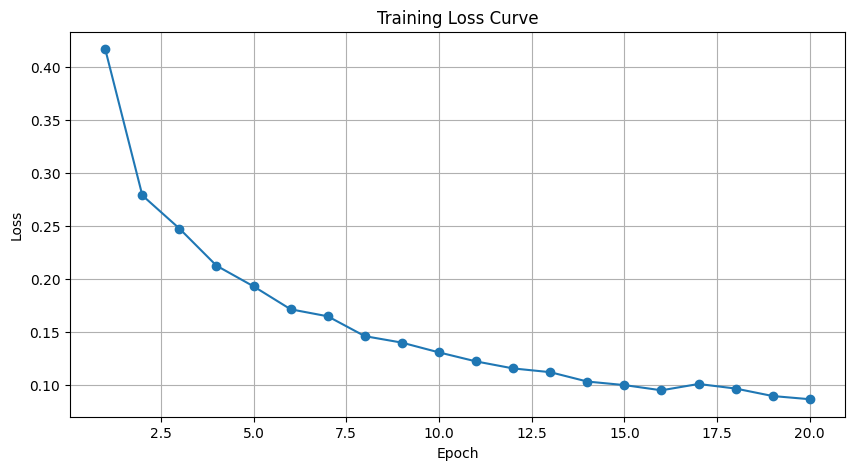

In [12]:
num_epochs = 20
losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    start_time = time.time()

    for imgs, masks in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    epoch_time = time.time() - start_time
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Time: {epoch_time:.1f}s')

    # 每 10 个 epoch 保存一次模型到 Drive
    if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
        save_path = f'/content/drive/MyDrive/unet_nuclei_epoch_{epoch+1}.pth'
        torch.save(model.state_dict(), save_path)
        print(f'Model saved to {save_path}')

# 绘制 Loss 曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


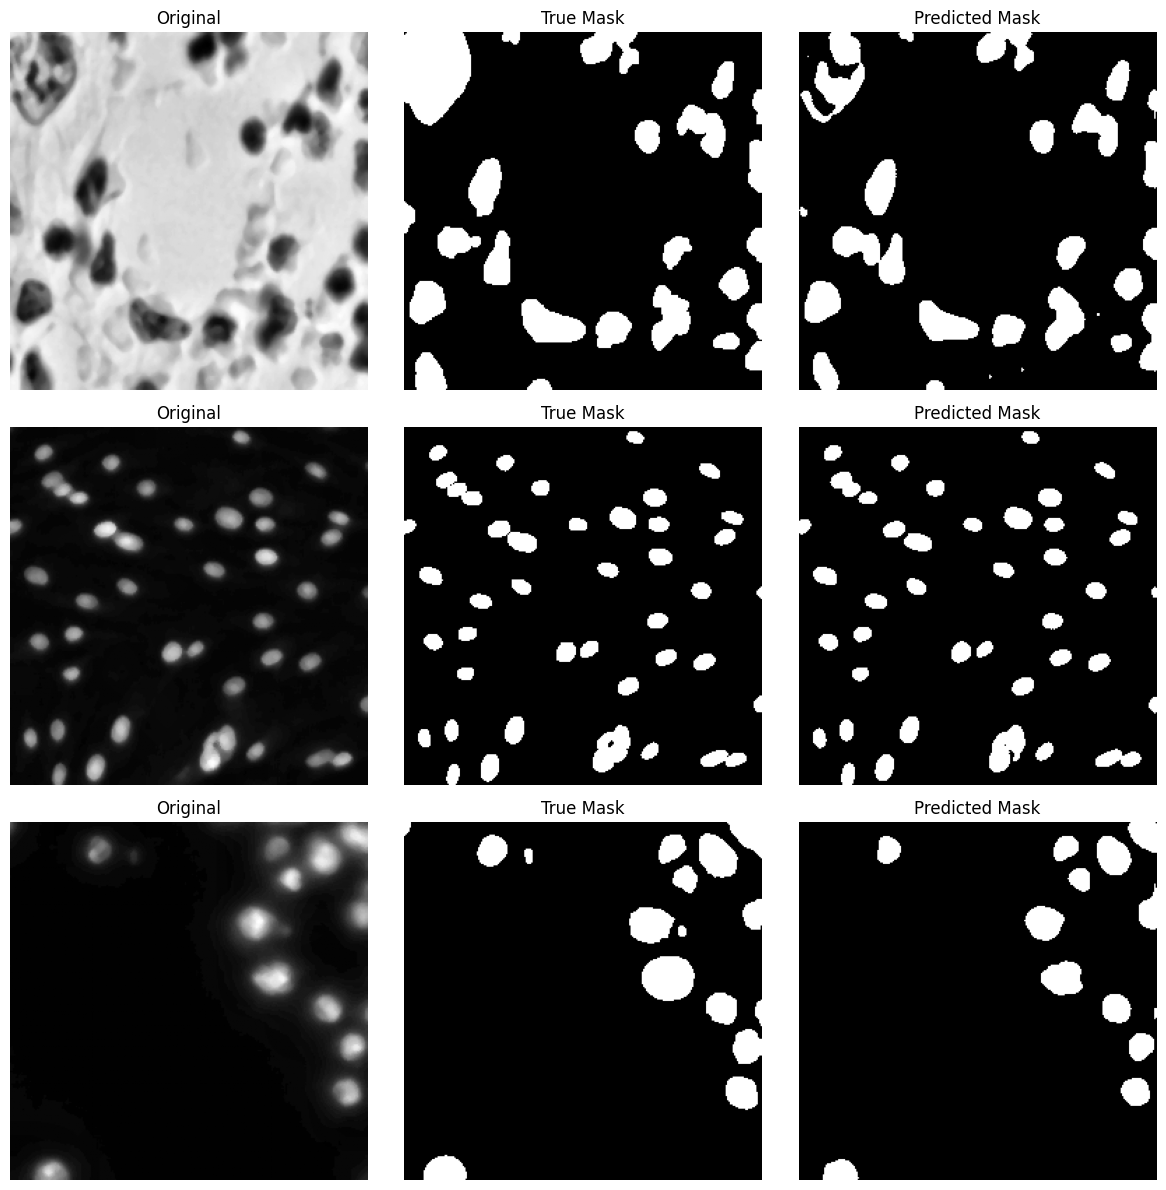

In [13]:
import random

model.eval()
with torch.no_grad():
    # 随机选 3 个样本
    indices = random.sample(range(len(dataset)), 3)
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    for i, idx in enumerate(indices):
        img, true_mask = dataset[idx]
        img_gpu = img.unsqueeze(0).to(device)  # 加 batch 维
        pred = model(img_gpu)
        pred_mask = torch.sigmoid(pred) > 0.5
        pred_mask = pred_mask.cpu().squeeze(0)

        # 原图
        axs[i, 0].imshow(img.squeeze(0), cmap='gray')
        axs[i, 0].set_title('Original')
        axs[i, 0].axis('off')

        # 真 mask
        axs[i, 1].imshow(true_mask.squeeze(0), cmap='gray')
        axs[i, 1].set_title('True Mask')
        axs[i, 1].axis('off')

        # 预测 mask
        axs[i, 2].imshow(pred_mask.squeeze(0), cmap='gray')
        axs[i, 2].set_title('Predicted Mask')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()